![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Extraction of Flood Features from UAV RGB Imagery

 - Sign up to the [VA Datacube](https://www.data4va.org/) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with the Virginia DataCube Sandbox environments      
 - <b>Products used</b>:
    UAV imagery of Colonial Place Site A (shared/UAV_test_imagery/SiteA-RGB.tiff)
 - <b>Special requirements:</b> None
 - <b>Prerequisites:</b> None
    

## Background

Unmanned aerial vehicles (UAVs), or drones, are proving to be valuable tools for mapping floods due to their ability to capture high-resolution aerial imagery over large areas quickly and safely. This enables researchers and emergency responders to assess flood damage and plan for recovery efforts more efficiently. The imagery captured by drones can be processed using both supervised and unsupervised classification techniques to generate detailed maps of the affected areas. In supervised classification, the drone imagery is classified using a pre-defined set of classes, such as water, vegetation, and buildings, while in unsupervised classification, the software identifies the various classes present in the imagery automatically. Both techniques have been successfully used in flood mapping studies, and we will be demonstrating methods within both categories here using an example from Norfolk, Virginia. 


## Description

A <i>compulsory</i> description of the notebook, including a brief overview of how the VA data cube helps to address the problem set out above. It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we will explore the histogram of the imagery
2. Then we will try a threshold method to extract flood footprints
3. Next we will use an unsupervised classification method to extract flood footprints
4. After that we will derive flood extent lines from both methods
5. Finally we will compare the results of both methods

---------------------------------------------------------------------------------------------------------------------------

## Getting started


Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [6]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from rasterio.enums import Resampling
from rasterio.windows import Window
from rasterio.transform import Affine
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sklearn import cluster
from sklearn.cluster import KMeans
from osgeo import gdal, gdal_array
from scipy.ndimage import zoom

#From DEA Africa Tools
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, xr_animation

### Connect to the datacube

Connect to the datacube so we can access VA data cube data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [2]:
dc = datacube.Datacube("UAV_floodFeature")

### Analysis parameters
An optional section to inform the user of any parameters they'll need to configure to run the notebook:
 - param_name_1: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.
 - param_name_2: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.

 

In [3]:
raster_path = '/home/jupyter-68bca889-0317-429c-8193d/shared/UAV_test_imagery/SiteA-RGB.tiff'

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 

To activate Dask, set up the local computing cluster using the cell below.

In [5]:
create_local_dask_cluster(memory_limit = '32GB')

distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-68bca889-0317-429c-8193d/Steiner_Notebooks/va-datacube/real_world_examples/dask-worker-space/worker-weekdl5y', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/68bca889-0317-429c-aa54-ad21f6435da5/proxy/8787/status,
Dashboard: /user/68bca889-0317-429c-aa54-ad21f6435da5/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 27.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32861,Workers: 1
Dashboard: /user/68bca889-0317-429c-aa54-ad21f6435da5/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 27.01 GiB
Comm: tcp://127.0.0.1:33879,Total threads: 4
Dashboard: /user/68bca889-0317-429c-aa54-ad21f6435da5/proxy/37311/status,Memory: 27.01 GiB
Nanny: tcp://127.0.0.1:37387,


## Using K Means to Extract Flood Footprint


### Read in the raster and plot the imagery

Let's read in one band of the GeoTiff and normalize the data for K means and see what we get. 

In [22]:
#Try loading the raster
raster_dataset = xr.open_rasterio(raster_path, chunks=(50,50)).rename(
    {"y": "latitude", "x": "longitude"}
)

raster_dataset = (
    raster_dataset.to_dataset(dim="band")
    .rename({1: "red", 2: "green", 3: "blue"})
    .drop_vars(4)
)


/tmp/ipykernel_1243352/1523463814.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  raster_dataset = xr.open_rasterio(raster_path, chunks=(50,50)).rename(


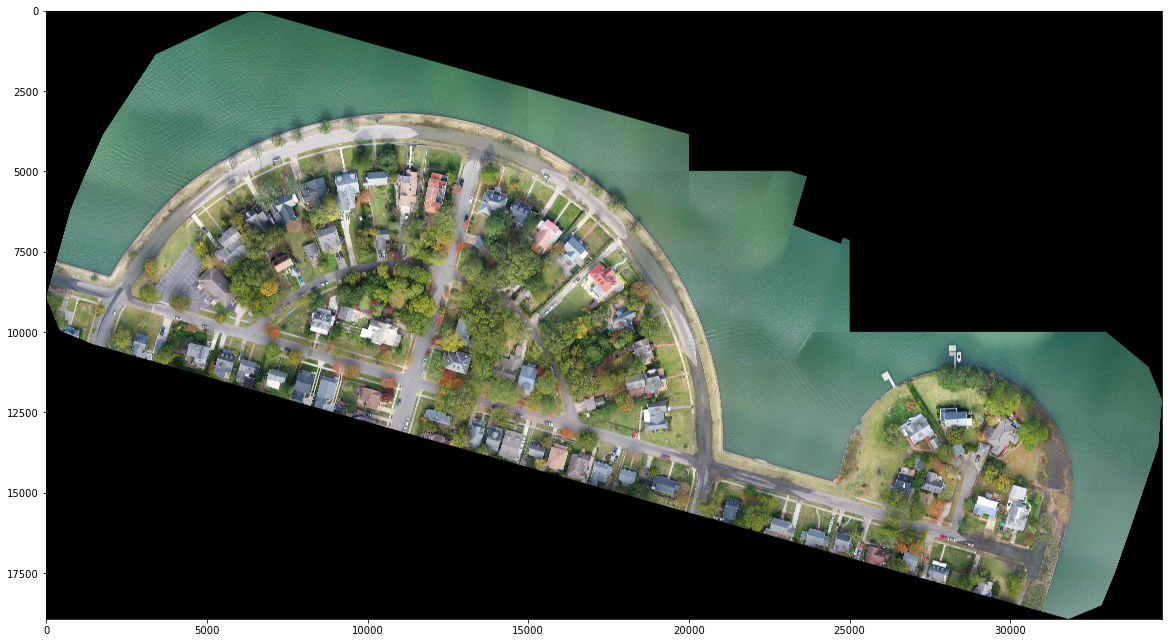

In [12]:
#Plot the drone Image
fig = plt.figure(figsize=(20,20))
plt.imshow(
    np.stack([
        raster_dataset.red,
        raster_dataset.green,
        raster_dataset.blue
    ], axis=2))

### Read in one band of the raster

Let's read in one band of the GeoTiff and normalize the data for K means and see what we get. 

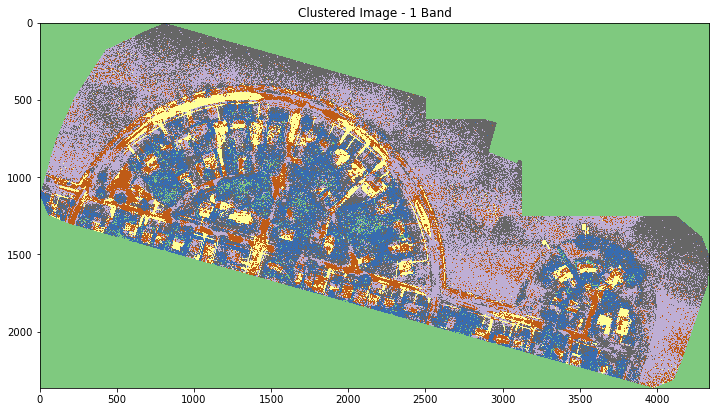

In [25]:
# Resample the drone image for efficient processing 
upscale_factor = 1/8

with rasterio.open(raster_path) as dataset:
    # Define the target shape after resampling
    target_height = int(dataset.height * upscale_factor)
    target_width = int(dataset.width * upscale_factor)

    # Resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            target_height,
            target_width
        ),
        resampling=Resampling.nearest
    )

    # Scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    # Get blue band
    blue = data[2]

    # Reshape the green band to match the expected shape
    blue_reshaped = blue.reshape(-1, 1)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=6, random_state=0).fit(blue_reshaped)
    labels = kmeans.predict(blue_reshaped)

    # Reshape the labels array back into a 2D array
    clustered_oneBand = labels.reshape(blue.shape)

    # Display clustered image
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(clustered_oneBand, cmap='Accent', interpolation='none')
    ax.set_title('Clustered Image - 1 Band')
    plt.show()

Using one band, we can see some of the limitations as k-means works to find similar clusters among the pixels. The blue band finds some similarities between the water and flooded streets, but it also finds similarities with shadows and flooded streets. 

Next we will try k-means with red, green, and blue bands. 

### Read in all three bands of the raster

Here, we are going to read in all three bands of the GeoTiff and normalize the data for K means. 

In [10]:
# Open the source dataset and read in via chunks to save memory
raster_data = xr.open_rasterio(raster_path, chunks="auto").rename(
    {"y": "latitude", "x": "longitude"}
)

#redefine raster dataset
raster_data = (
    raster_data.to_dataset(dim="band")
    .rename({1: "red", 2: "green", 3: "blue"})
    .drop_vars(4)
)

#Check dataset
raster_data

/tmp/ipykernel_1210087/356632055.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  raster_data = xr.open_rasterio(raster_path, chunks="auto").rename(


<xarray.Dataset>
Dimensions:    (latitude: 18922, longitude: 34721)
Coordinates:
  * latitude   (latitude) float64 4.084e+06 4.084e+06 ... 4.083e+06 4.083e+06
  * longitude  (longitude) float64 3.85e+05 3.85e+05 ... 3.858e+05 3.858e+05
Data variables:
    red        (latitude, longitude) uint8 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    green      (latitude, longitude) uint8 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    blue       (latitude, longitude) uint8 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
Attributes:
    transform:         (0.020730000000000002, 0.0, 385043.41551, 0.0, -0.0207...
    crs:               +init=epsg:32618
    res:               (0.020730000000000002, 0.020730000000000002)
    is_tiled:          0
    nodatavals:        (nan, nan, nan, nan)
    scales:            (1.0, 1.0, 1.0, 1.0)
    offsets:           (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  pix4dmapper

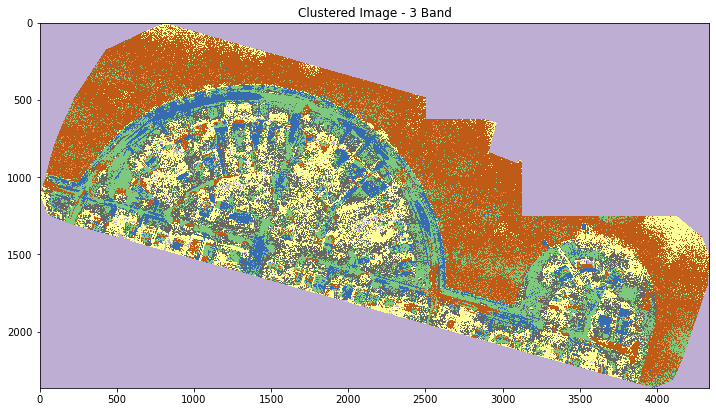

In [11]:
# Resample the drone image for efficient processing 
upscale_factor = 1/8

with rasterio.open(raster_path) as dataset:
    # Define the target shape after resampling
    target_height = int(dataset.height * upscale_factor)
    target_width = int(dataset.width * upscale_factor)

    # Resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            target_height,
            target_width
        ),
        resampling=Resampling.nearest
    )

    # Scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    # Get red, green, and blue bands
    red = data[0]
    green = data[1]
    blue = data[2]

    # Reshape to a 2D array for k-means clustering
    X = np.column_stack([red.flatten(), green.flatten(), blue.flatten()])

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
    labels = kmeans.predict(X)

    # Reshape the labels array back into a 2D array
    clustered = labels.reshape(red.shape)

    # Display clustered image
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(clustered, cmap='Accent', interpolation='none')
    ax.set_title('Clustered Image - 3 Band')
    plt.show()

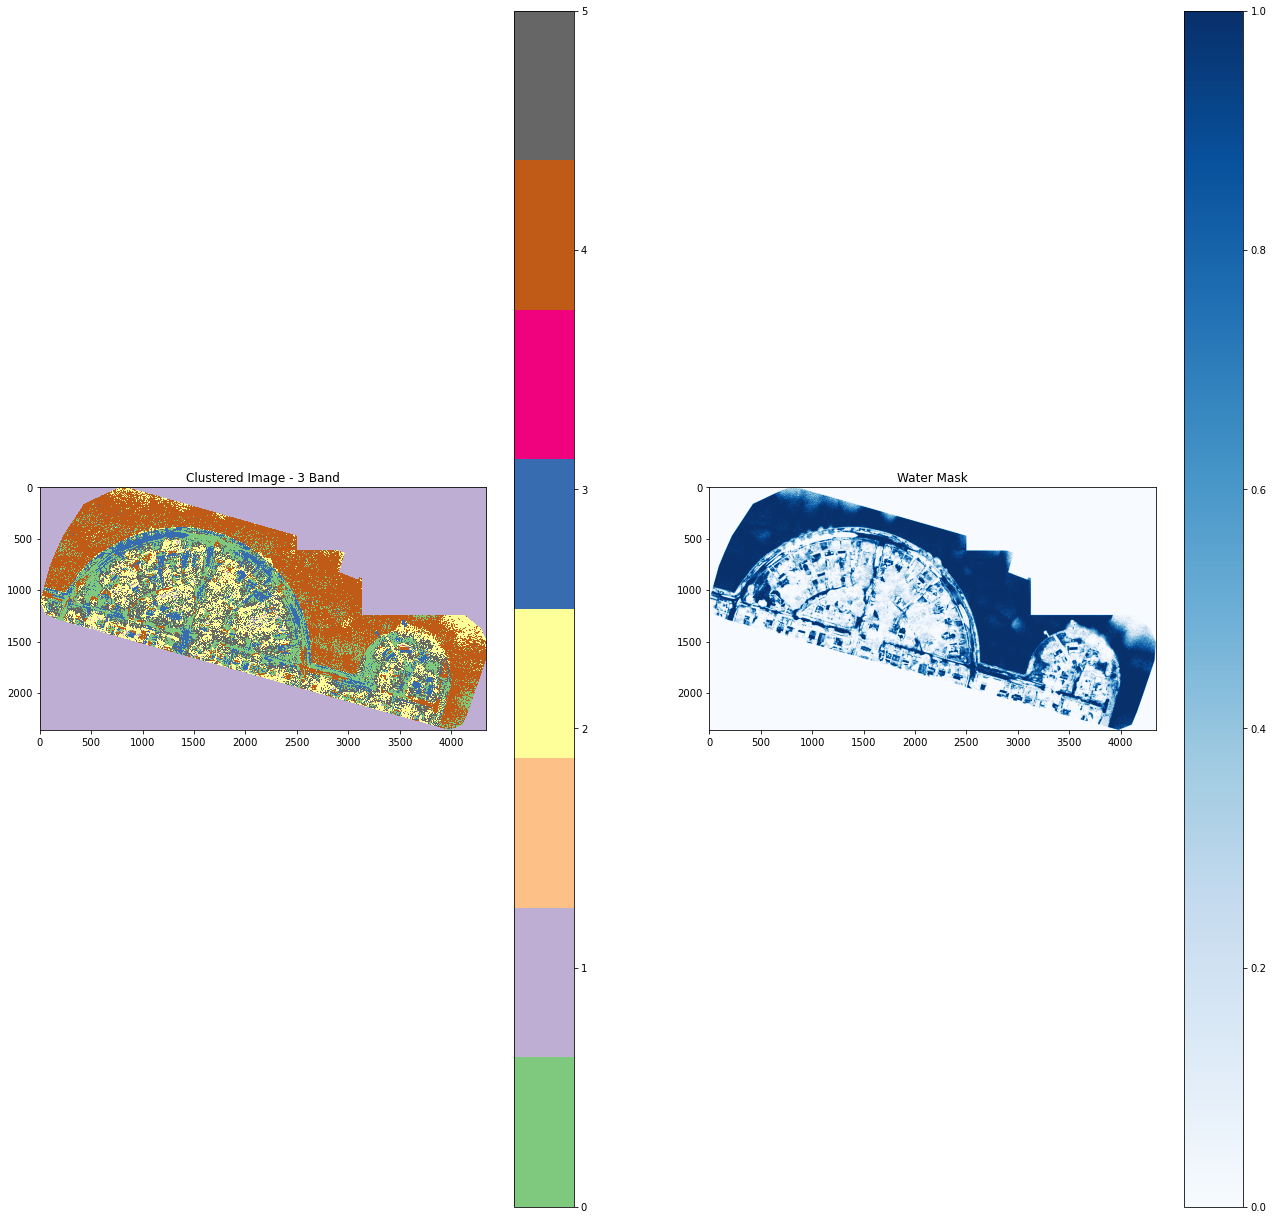

In [20]:
# Resample the drone image for efficient processing 
upscale_factor = 1/8

with rasterio.open(raster_path) as dataset:
    # Define the target shape after resampling
    target_height = int(dataset.height * upscale_factor)
    target_width = int(dataset.width * upscale_factor)

    # Resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            target_height,
            target_width
        ),
        resampling=Resampling.nearest
    )

    # Scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    # Get red, green, and blue bands
    red = data[0]
    green = data[1]
    blue = data[2]

    # Reshape to a 2D array for k-means clustering
    X = np.column_stack([red.flatten(), green.flatten(), blue.flatten()])

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
    labels = kmeans.predict(X)

    # Reshape the labels array back into a 2D array
    clustered = labels.reshape(red.shape)

    # Create a binary water mask using the labels
    water_mask = np.zeros_like(clustered)
    water_mask[np.isin(clustered, [0, 4])] = 1  # Use multiple labels to detect water in the image

    # Display clustered image
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(22,22))

    im1 = ax1.imshow(clustered, cmap='Accent', interpolation='none')
    ax1.set_title('Clustered Image - 3 Band')
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(water_mask, cmap='Blues')
    ax2.set_title('Water Mask')
    fig.colorbar(im2, ax=ax2)

    plt.show()


Now let's plot our true-color composite, one-band, and three-band classified imagery. 

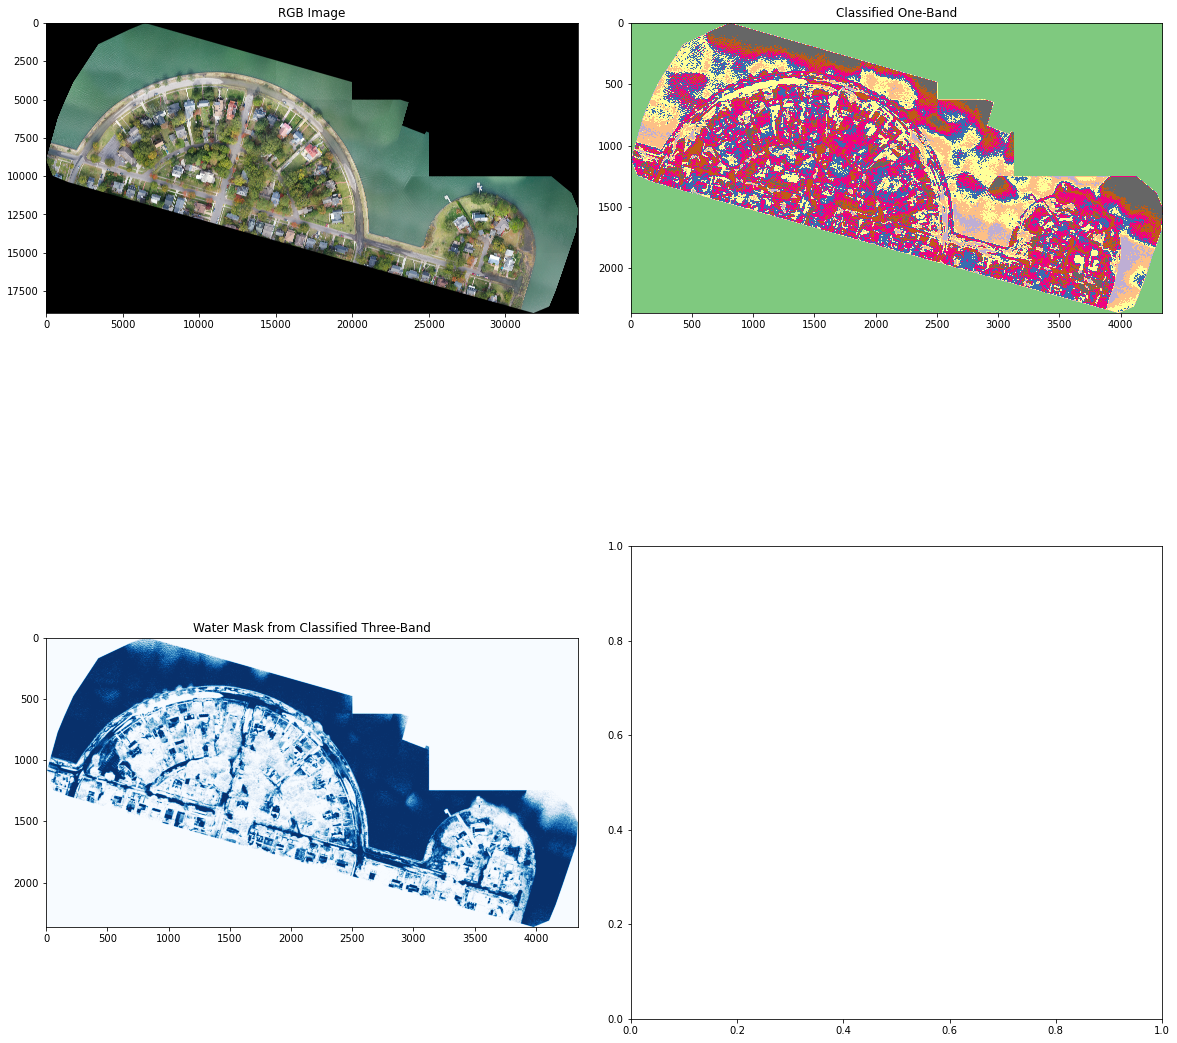

In [26]:
# Create a figure with four subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# Plot the 3-band geotiff in the first subplot
axs[0, 0].imshow(np.stack([
        raster_dataset.red,
        raster_dataset.green,
        raster_dataset.blue
    ], axis=2))

# Set the title of the first subplot
axs[0, 0].set_title('RGB Image')

# Plot the first classified image in the second subplot
axs[0, 1].imshow(clustered_oneBand, cmap='Accent')

# Set the title of the second subplot
axs[0, 1].set_title('Classified One-Band')

# Plot the second classified image in the third subplot
axs[1, 0].imshow(water_mask, cmap='Blues')

# Set the title of the third subplot
axs[1, 0].set_title('Water Mask from Classified Three-Band')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Display the figure
plt.show()


It looks as though the three-banded classified image in the bottom left does a better job at distinguishing patterns than the one banded image. However, there is still confusion between shadows and water, along with confusion between flooded areas at the bottom right and the top of the neighborhood on the edge of the water (top left image in the figure). 

Next, we will explore supervised classification methods. 

In [14]:
%matplotlib inline
upscale_factor = 1/8

# Load the RGB geotiff
with rasterio.open(raster_path) as dataset:
    
    # Define the target shape after resampling
    target_height = int(dataset.height * upscale_factor)
    target_width = int(dataset.width * upscale_factor)

    # Resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            target_height,
            target_width
        ),
        resampling=Resampling.nearest
    )

    # Scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    # Get red, green, and blue bands
    red = data[0]
    green = data[1]
    blue = data[2]
    
    # Combine the red, green, and blue bands to create an RGB image
    rgb = np.stack([red, green, blue], axis=0)

    # Reshape the RGB image to match the target shape
    rgb = np.transpose(rgb, (1, 2, 0))

    # Reshape to a 2D array for k-means clustering
    X = np.column_stack([red.flatten(), green.flatten(), blue.flatten()])

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
    labels = kmeans.predict(X)

    # Get the cluster labels for each pixel
    labels = kmeans.labels_

    # Reshape the labels back to the original image shape
    labels_2d = labels.reshape((target_height, target_width))

    # Create a binary water mask using the labels
    water_mask = np.zeros_like(labels_2d)
    water_mask[np.isin(labels_2d, [2])] = 1  # Use multiple labels to detect water in the image

# Plot the RGB image and water mask side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(rgb, transform=transform)
ax1.set_title('Upscaled RGB Image')
ax2.imshow(water_mask, cmap='Accent')
ax2.set_title('Water Mask')
plt.show()


TypeError: 'transform' must be an instance of matplotlib.transforms.Transform, not a affine.Affine

<Figure size 864x432 with 2 Axes>

## Heading 2

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.


In [1]:
# Use code comments for low-level documentation of code
c = 3

## Additional information

<b>License:</b> The code in this notebook is licensed under the Apache License, Version 2.0. Digital Earth Australia data is licensed under the Creative Commons by Attribution 4.0 license.

<b>Contact:</b> If you need assistance, please post a question on the Open Data Cube Slack channel or on the GIS Stack Exchange using the open-data-cube tag (you can view previously asked questions here). If you would like to report an issue with this notebook, you can file one on Github.

<b>Last modified:</b> May 2020

<b>Compatible datacube version:</b>

In [ ]:
print(datacube.__version__)

## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 